# Importation du fichier

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import scipy.stats as sps
from scipy.stats import chi2

# On lit les premiers jeux de données, qu'on utilisera plusieurs fois ci-dessous.
df = pd.read_csv('nom du fichier à traiter pour les parties 1 ou 2', sep = ';')

# 1.Cas d'un seul photon

## Histogramme

In [245]:
# Histogramme des mesures
data = df
obs = np.asarray(data.alpha[data.X == 1]).reshape(-1,1)
plt.hist(obs, bins = 10)

AttributeError: 'DataFrame' object has no attribute 'X'

## Angle de polarisation et p-value

In [281]:
# On va travailler sur le jeu de données '1photon-30.csv', lu ci-dessus dans df_30.
# Remarquer que les angles de mesure sont réguliers, c'est ce qui va nous permettre
# de calculer des valeurs-p ci-dessous.
data = df
obs = data.X
table_alpha = data.alpha[data.X != data.Y] # Si X=Y=1 -> bruit, si X=Y=0 pas possible dans nos conditions
# Définir une fonction pour la loi de probabilité, en fonction des angles en degrés.
# La fonction peut opérer sur des nombres ou des tableaux.
def f_proba(alpha, theta):
    return np.cos(np.radians(alpha - theta)) ** 2

# Définir une fonction de vraisemblance. (Spécifique aux valeurs de table_alpha.)
def L(theta):
    table_probas = f_proba(table_alpha, theta)
    return (np.sum(np.log(table_probas[obs == 1]))
           + np.sum(np.log(1 - table_probas[obs == 0]))
           )

# Repérer l'angle ayant le maximum de vraisemblance à 0.1 degré près (overkill).
test_theta = np.arange(0, 180, 0.1)
indice_MLE = np.argmax(np.asarray([L(theta) for theta in test_theta]))
theta_MLE = test_theta[indice_MLE]
round_theta = round(theta_MLE)
print("l'angle de polarisation est:" + str(theta_MLE) + " soit, arrondi au degré près: "+ str(round_theta))
# Calcul des valeurs-p pour chaque angle de mesure rencontré,
# à partir du nombre de fois où on l'a rencontré et de la valeur
# moyenne de l'observation en X.
table_alpha_uniques = np.unique(table_alpha)
nb_alpha = np.asarray([len(table_alpha[table_alpha == a]) for a in table_alpha_uniques])
moyenne_obs_alpha = np.asarray([np.mean(obs[table_alpha == a]) for a in table_alpha_uniques])
t = sps.norm.ppf(0.05)

# Le bloc suivant élimine les angles pour lesquels les probabilités
# sont trop hautes ou trop basses.  Essayez sans pour voir ;
# pourquoi posent-elles problème ?
indices_alpha_ok = (moyenne_obs_alpha > 0.1) & (moyenne_obs_alpha < 0.9)
table_alpha_uniques = table_alpha_uniques[indices_alpha_ok]
moyenne_obs_alpha = moyenne_obs_alpha[indices_alpha_ok]
nb_alpha = nb_alpha[indices_alpha_ok]

# Fonction pour calculer la valeur-p pour un theta spécifique.
def pvalue(theta):
    # Probabilité attendue pour chaque angle.
    p0 = f_proba(table_alpha_uniques, theta)

    # Valeur-p pour chaque angle.
    pvalues = [2*(1 - sps.norm.cdf(abs(p - x)*(n/(p*(1-p)))**0.5))
               for p,x,n in zip(moyenne_obs_alpha, p0, nb_alpha)]

    # Combinaison des valeurs-p par la méthode de Fisher.
    Tchi = -2 * sum([np.log(x) for x in pvalues])

    # Retrouver la valeur-p correspondante via la distribution chi²
    # avec 2*(nombre de valeurs-p) degrés de liberté.
    return 1 - sps.chi2.cdf(Tchi, 2*len(table_alpha_uniques))

# Intervalle de confiance.
table_pvalues = np.asarray([pvalue(theta) for theta in test_theta])
print("la p-value correspondante à cet angle de polarisation est :" + str(pvalue(round(theta_MLE))))
indices_pvaleur_grande = np.where(table_pvalues > 0.05)[0]
CI = [test_theta[indices_pvaleur_grande[0]], test_theta[indices_pvaleur_grande[-1]]]
CI

AttributeError: 'DataFrame' object has no attribute 'X'

## Régression linaire


In [259]:
data = df
obs = np.asarray(data.alpha[data.X == 1]-round_theta).reshape(-1,1)
(comptage, alpha_bords) = np.histogram(obs, bins = 20)
alpha_centres = (alpha_bords[0:-1] + alpha_bords[1:]) / 2
cos2_alpha = np.cos(np.radians(alpha_centres)) ** 2
cos2_alpha = cos2_alpha.reshape(-1, 1)
#X = np.asarray([(hist[1][i] + hist[1][i+1])/2 for i in range(0,len(hist[1])-1)]).reshape(-1,1)
#X = np.asarray([math.cos(math.radians(x))**2 for x in X]).reshape(-1,1)
reg = LinearRegression().fit(cos2_alpha, comptage)
plt.scatter(cos2_alpha, comptage, label="Train data points")
plt.plot(cos2_alpha,
    reg.predict(cos2_alpha),
    linewidth=3,
    color="tab:orange",
    label="Model predictions",)

reg.score(cos2_alpha, comptage)

mod = sm.OLS(cos2_alpha, comptage)
fit = mod.fit()
fit.summary()

AttributeError: 'DataFrame' object has no attribute 'X'

# 2.Cas de 2 photons

## Histogramme

(array([ 96., 101., 106.,   0., 108., 108.,   0., 106., 105.,   0., 105.,
         94.,  90.,   0.,  76.,  69.,   0.,  59.,  51.,   0.,  46.,  36.,
         37.,   0.,  24.,  16.,   0.,   4.,   6.,   0.,   1.,   0.,   2.,
          0.,   6.,   7.,   0.,   7.,  18.,   0.,  25.,  32.,  39.,   0.,
         55.,  70.,   0.,  74.,  83., 259.]),
 array([  0. ,   3.5,   7. ,  10.5,  14. ,  17.5,  21. ,  24.5,  28. ,
         31.5,  35. ,  38.5,  42. ,  45.5,  49. ,  52.5,  56. ,  59.5,
         63. ,  66.5,  70. ,  73.5,  77. ,  80.5,  84. ,  87.5,  91. ,
         94.5,  98. , 101.5, 105. , 108.5, 112. , 115.5, 119. , 122.5,
        126. , 129.5, 133. , 136.5, 140. , 143.5, 147. , 150.5, 154. ,
        157.5, 161. , 164.5, 168. , 171.5, 175. ]),
 <BarContainer object of 50 artists>)

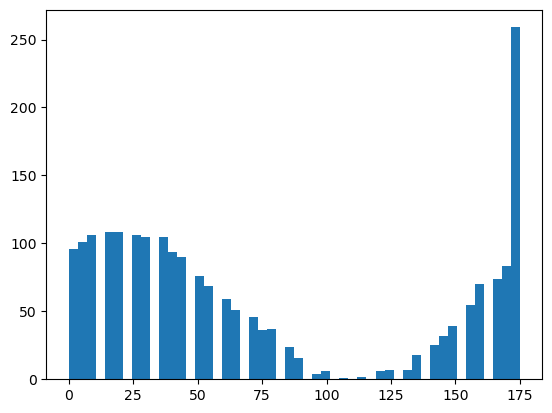

In [282]:
# Histogramme des mesures
data = df
obs = np.asarray(data.alpha[data.Xalpha == 1]).reshape(-1,1)
plt.hist(obs, bins = 50)

(array([ 95., 104., 105.,   0., 108., 108.,   0., 107., 103.,   0., 101.,
         98.,  87.,   0.,  86.,  66.,   0.,  58.,  54.,   0.,  42.,  33.,
         29.,   0.,  15.,  16.,   0.,   4.,   1.,   0.,   1.,   0.,   1.,
          0.,   4.,   7.,   0.,  12.,  22.,   0.,  31.,  35.,  40.,   0.,
         53.,  63.,   0.,  78.,  86., 250.]),
 array([  0. ,   3.5,   7. ,  10.5,  14. ,  17.5,  21. ,  24.5,  28. ,
         31.5,  35. ,  38.5,  42. ,  45.5,  49. ,  52.5,  56. ,  59.5,
         63. ,  66.5,  70. ,  73.5,  77. ,  80.5,  84. ,  87.5,  91. ,
         94.5,  98. , 101.5, 105. , 108.5, 112. , 115.5, 119. , 122.5,
        126. , 129.5, 133. , 136.5, 140. , 143.5, 147. , 150.5, 154. ,
        157.5, 161. , 164.5, 168. , 171.5, 175. ]),
 <BarContainer object of 50 artists>)

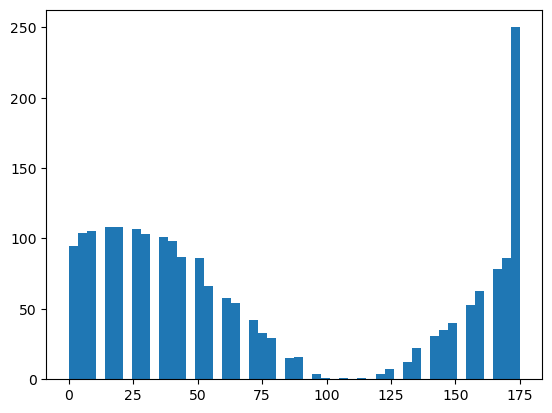

In [283]:
# Histogramme des mesures
data = df
obs = np.asarray(data.beta[data.Xbeta == 1]).reshape(-1,1)
plt.hist(obs, bins = 50)

## Angle de polarisation et p-value

In [10]:
def polarisation_alpha(data,pas):
    # On va travailler sur le jeu de données '1photon-30.csv', lu ci-dessus dans df_30.
    # Remarquer que les angles de mesure sont réguliers, c'est ce qui va nous permettre
    # de calculer des valeurs-p ci-dessous.
    obs = data.Xalpha
    table_alpha = data.alpha[data.Xalpha != data.Yalpha] # Si X=Y=1 -> bruit, si X=Y=0 pas possible dans nos conditions
    # Définir une fonction pour la loi de probabilité, en fonction des angles en degrés.
    # La fonction peut opérer sur des nombres ou des tableaux.
    def f_proba(alpha, theta):
        return np.cos(np.radians(alpha - theta)) ** 2

    # Définir une fonction de vraisemblance. (Spécifique aux valeurs de table_alpha.)
    def L(theta):
        table_probas = f_proba(table_alpha, theta)
        return (np.sum(np.log(table_probas[obs == 1]))
            + np.sum(np.log(1 - table_probas[obs == 0]))
            )

    # Repérer l'angle ayant le maximum de vraisemblance à 0.1 degré près (overkill).
    test_theta = np.arange(0, 180, pas)
    indice_MLE = np.argmax(np.asarray([L(theta) for theta in test_theta]))
    theta_MLE = test_theta[indice_MLE]
    round_theta = round(theta_MLE)

    # Calcul des valeurs-p pour chaque angle de mesure rencontré,
    # à partir du nombre de fois où on l'a rencontré et de la valeur
    # moyenne de l'observation en X.
    table_alpha_uniques = np.unique(table_alpha)
    nb_alpha = np.asarray([len(table_alpha[table_alpha == a]) for a in table_alpha_uniques])
    moyenne_obs_alpha = np.asarray([np.mean(obs[table_alpha == a]) for a in table_alpha_uniques])
    t = sps.norm.ppf(0.05)

    # Le bloc suivant élimine les angles pour lesquels les probabilités
    # sont trop hautes ou trop basses.  Essayez sans pour voir ;
    # pourquoi posent-elles problème ?
    indices_alpha_ok = (moyenne_obs_alpha > 0.1) & (moyenne_obs_alpha < 0.9)
    table_alpha_uniques = table_alpha_uniques[indices_alpha_ok]
    moyenne_obs_alpha = moyenne_obs_alpha[indices_alpha_ok]
    nb_alpha = nb_alpha[indices_alpha_ok]

    # Fonction pour calculer la valeur-p pour un theta spécifique.
    def pvalue(theta):
        # Probabilité attendue pour chaque angle.
        p0 = f_proba(table_alpha_uniques, theta)

        # Valeur-p pour chaque angle.
        pvalues = [2*(1 - sps.norm.cdf(abs(p - x)*(n/(p*(1-p)))**0.5))
                for p,x,n in zip(moyenne_obs_alpha, p0, nb_alpha)]

        # Combinaison des valeurs-p par la méthode de Fisher.
        Tchi = -2 * sum([np.log(x) for x in pvalues])

        # Retrouver la valeur-p correspondante via la distribution chi²
        # avec 2*(nombre de valeurs-p) degrés de liberté.
        return 1 - sps.chi2.cdf(Tchi, 2*len(table_alpha_uniques))

    # Intervalle de confiance.
    table_pvalues = np.asarray([pvalue(theta) for theta in test_theta])
    pvalue = pvalue(round(theta_MLE))


    indices_pvaleur_grandes = np.where(table_pvalues > 0.05)[0]
   
    if len(indices_pvaleur_grandes) == 0:
        pvalue = -1
    
    #CI = [test_theta[indices_pvaleur_grande[0]], test_theta[indices_pvaleur_grande[-1]]]
        
    return round_theta, pvalue
    

polarisation_alpha(df,2.5)

/usr/lib/python3/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1145721/701476291.py:51: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])


(32, -1)

In [11]:
def polarisation_beta(data,pas):
    # On va travailler sur le jeu de données '1photon-30.csv', lu ci-dessus dans df_30.
    # Remarquer que les angles de mesure sont réguliers, c'est ce qui va nous permettre
    # de calculer des valeurs-p ci-dessous.
    obs = data.Xbeta
    table_alpha = data.beta[data.Xbeta != data.Ybeta] # Si X=Y=1 -> bruit, si X=Y=0 pas possible dans nos conditions
    # Définir une fonction pour la loi de probabilité, en fonction des angles en degrés.
    # La fonction peut opérer sur des nombres ou des tableaux.
    def f_proba(alpha, theta):
        return np.cos(np.radians(alpha - theta)) ** 2

    # Définir une fonction de vraisemblance. (Spécifique aux valeurs de table_alpha.)
    def L(theta):
        table_probas = f_proba(table_alpha, theta)
        return (np.sum(np.log(table_probas[obs == 1]))
            + np.sum(np.log(1 - table_probas[obs == 0]))
            )

    # Repérer l'angle ayant le maximum de vraisemblance à 0.1 degré près (overkill).

    test_theta1 = np.arange(0, 180, pas)
    indice_MLE1 = np.argmax(np.asarray([L(theta) for theta in test_theta1]))
    theta_MLE1 = test_theta1[indice_MLE1]
    round_theta1 = round(theta_MLE1)
  
    # Calcul des valeurs-p pour chaque angle de mesure rencontré,
    # à partir du nombre de fois où on l'a rencontré et de la valeur
    # moyenne de l'observation en X.
    table_alpha_uniques = np.unique(table_alpha)
    nb_alpha = np.asarray([len(table_alpha[table_alpha == a]) for a in table_alpha_uniques])
    moyenne_obs_alpha = np.asarray([np.mean(obs[table_alpha == a]) for a in table_alpha_uniques])
    t = sps.norm.ppf(0.05)

    # Le bloc suivant élimine les angles pour lesquels les probabilités
    # sont trop hautes ou trop basses.  Essayez sans pour voir ;
    # pourquoi posent-elles problème ?
    indices_alpha_ok = (moyenne_obs_alpha > 0.1) & (moyenne_obs_alpha < 0.9)
    table_alpha_uniques = table_alpha_uniques[indices_alpha_ok]
    moyenne_obs_alpha = moyenne_obs_alpha[indices_alpha_ok]
    nb_alpha = nb_alpha[indices_alpha_ok]

    # Fonction pour calculer la valeur-p pour un theta spécifique.
    def pvalue(theta):
        # Probabilité attendue pour chaque angle.
        p0 = f_proba(table_alpha_uniques, theta)

        # Valeur-p pour chaque angle.
        pvalues = [2*(1 - sps.norm.cdf(abs(p - x)*(n/(p*(1-p)))**0.5))
                for p,x,n in zip(moyenne_obs_alpha, p0, nb_alpha)]

        # Combinaison des valeurs-p par la méthode de Fisher.
        Tchi = -2 * sum([np.log(x) for x in pvalues])

        # Retrouver la valeur-p correspondante via la distribution chi²
        # avec 2*(nombre de valeurs-p) degrés de liberté.
        return 1 - sps.chi2.cdf(Tchi, 2*len(table_alpha_uniques))

    # Intervalle de confiance.
    table_pvalues = np.asarray([pvalue(theta) for theta in test_theta1])
    pvalue1 = pvalue(round(theta_MLE1))
  
    indices_pvaleur_grandes = np.where(table_pvalues > 0.05)[0]
    
    if len(indices_pvaleur_grandes) == 0:
        pvalue1 = -1
    
    #CI = [test_theta[indices_pvaleur_grande[0]], test_theta[indices_pvaleur_grande[-1]]]
    #CI
    return round_theta1, pvalue1
    
polarisation_beta(df,2.5)


/tmp/ipykernel_1145721/2067034763.py:52: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])


(38, -1)

## Régression linaire

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.508
Model:                            OLS   Adj. R-squared (uncentered):              0.483
Method:                 Least Squares   F-statistic:                              19.65
Date:                Fri, 07 Feb 2025   Prob (F-statistic):                    0.000285
Time:                        11:12:51   Log-Likelihood:                         -11.751
No. Observations:                  20   AIC:                                      25.50
Df Residuals:                      19   BIC:                                      26.50
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0043      0.001      4.433      0.000       0.002       0.006
==============================================================================
Omnibus:                        1.125   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                1.019
Skew:                          -0.397   Prob(JB):                        0.601
Kurtosis:                       2.231   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

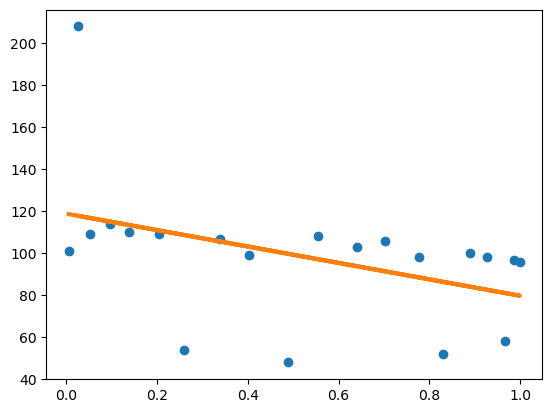

In [170]:
data = df
obs = np.asarray(data.alpha[data.Xalpha == 1]-round_theta).reshape(-1,1)
(comptage, alpha_bords) = np.histogram(obs, bins = 20)
alpha_centres = (alpha_bords[0:-1] + alpha_bords[1:]) / 2
cos2_alpha = np.cos(np.radians(alpha_centres)) ** 2
cos2_alpha = cos2_alpha.reshape(-1, 1)
#X = np.asarray([(hist[1][i] + hist[1][i+1])/2 for i in range(0,len(hist[1])-1)]).reshape(-1,1)
#X = np.asarray([math.cos(math.radians(x))**2 for x in X]).reshape(-1,1)
reg = LinearRegression().fit(cos2_alpha, comptage)
plt.scatter(cos2_alpha, comptage, label="Train data points")
plt.plot(cos2_alpha,
    reg.predict(cos2_alpha),
    linewidth=3,
    color="tab:orange",
    label="Model predictions",)

reg.score(cos2_alpha, comptage)

mod = sm.OLS(cos2_alpha, comptage)
fit = mod.fit()
ra= fit.rsquared
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.296
Model:                            OLS   Adj. R-squared (uncentered):              0.259
Method:                 Least Squares   F-statistic:                              7.995
Date:                Fri, 07 Feb 2025   Prob (F-statistic):                      0.0108
Time:                        11:12:54   Log-Likelihood:                         -15.340
No. Observations:                  20   AIC:                                      32.68
Df Residuals:                      19   BIC:                                      33.68
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0026      0.001      2.827      0.011       0.001       0.005
==============================================================================
Omnibus:                        4.109   Durbin-Watson:                   0.116
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                1.531
Skew:                          -0.217   Prob(JB):                        0.465
Kurtosis:                       1.716   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

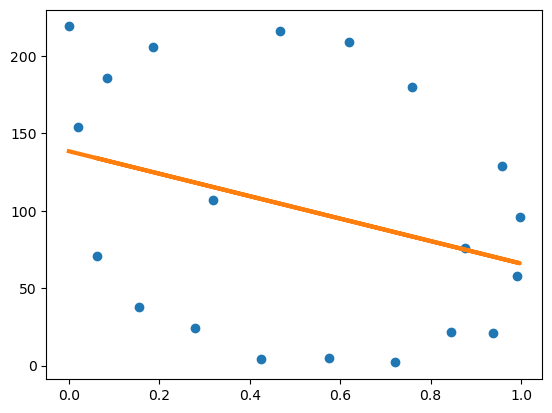

In [171]:
data = df
obs = np.asarray(data.beta[data.Xbeta == 1]-round_theta1).reshape(-1,1)
(comptage, beta_bords) = np.histogram(obs, bins = 20)
beta_centres = (beta_bords[0:-1] + beta_bords[1:]) / 2
cos2_beta = np.cos(np.radians(beta_centres)) ** 2
cos2_beta = cos2_beta.reshape(-1, 1)
#X = np.asarray([(hist[1][i] + hist[1][i+1])/2 for i in range(0,len(hist[1])-1)]).reshape(-1,1)
#X = np.asarray([math.cos(math.radians(x))**2 for x in X]).reshape(-1,1)
reg = LinearRegression().fit(cos2_beta, comptage)
plt.scatter(cos2_beta, comptage, label="Train data points")
plt.plot(cos2_beta,
    reg.predict(cos2_beta),
    linewidth=3,
    color="tab:orange",
    label="Model predictions",)

reg.score(cos2_beta, comptage)

mod = sm.OLS(cos2_beta, comptage)
fit = mod.fit()
rb=fit.rsquared
fit.summary()

## Corrélés ou pas ?

In [56]:

obs =  np.asarray([1 if df.Xalpha[x] == 1 and df.Xbeta[x] == 1 else 0 for x in range(len(df.Xalpha))])
# trouver des angles uniques pour lesquels générer les p values
dif = (df.alpha - df.beta) % 180
unique_dif = np.unique(dif)
#Calculer la moyenne des observations pour chaque angle
means = np.asarray([np.mean(obs[np.where(dif == y)]) for y in unique_dif])
#Garder le mal angle
indices_means_bad = np.concatenate((np.where(means < 0.1)[0],np.where(means > 0.9)[0]))
#Garder le nombre d'observations pour chaque angle
lengths = [len(obs[np.where(dif == y)]) for y in unique_dif]
#calculer la probabilité attendue d'observance pour chaque angle donné thêta
p0 = [0.5*math.cos(np.radians(x))**2 for x in unique_dif]
#supprimer
means = np.delete(means,indices_means_bad,0)
lengths = np.delete(lengths,indices_means_bad,0)
p0 = np.delete(p0,indices_means_bad,0)
#calculer p value pour chaque angle
Ts = [abs(p - x)*(n/(p*(1-p)))**0.5 for p,x,n in zip(means,p0,lengths)]
pvalues = [2*(1 - sps.norm.cdf(abs(p - x)*(n/(p*(1-p)))**0.5)) for p,x,n in zip(means,p0,lengths)]
#Combiner la p values avec Fisher's method
Tchi = -2*sum([np.log(x) for x in pvalues])
#trouver nouvelle pvalue via chi^2 dist avec 2*(Num pvalues) degrees de liberte
pvalue = 1 - sps.chi2.cdf(Tchi,2*len(p0))
print(pvalue)

if pvalue < 0.1 :
    print("indépendants")
else :
    print("corrélés")


0.0
indépendants


# 3.Bases de données multiples

## Nombre intrications

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import scipy.stats as sps
from scipy.stats import chi2
import re

# On lit les premiers jeux de données, qu'on utilisera plusieurs fois ci-dessous.
folder_path = 'chemin vers le dossier contenant tous les fichiers .csv à traiter.'
corr_cpt=0
ind_cpt=0

numero_fichier = 42 #PARAMETRE A MODIFIER
i=0
filenames = [f for f in os.listdir(folder_path) if f.startswith('dataset-') and f.endswith('.csv')]

# Trier en extrayant le nombre qui suit le tiret dans le nom du fichier
filenames = sorted(filenames, key=lambda x: int(re.search(r'-(\d+)', x).group(1)))

# Affichage pour vérifier l'ordre
for i, filename in enumerate(filenames, start=0):
    file_path=os.path.join(folder_path, filename)
    df = pd.read_csv(file_path, sep = ';')


    obs =  np.asarray([1 if df.Xalpha[x] == 1 and df.Xbeta[x] == 1 else 0 for x in range(len(df.Xalpha))])
    # trouver des angles uniques pour lesquels générer les p values
    dif = (df.alpha - df.beta) % 180
    unique_dif = np.unique(dif)
    #Calculer la moyenne des observations pour chaque angle
    means = np.asarray([np.mean(obs[np.where(dif == y)]) for y in unique_dif])
    #Garder le mal angle
    indices_means_bad = np.concatenate((np.where(means < 0.1)[0],np.where(means > 0.9)[0]))
    #Garder le nombre d'observations pour chaque angle
    lengths = [len(obs[np.where(dif == y)]) for y in unique_dif]
    #calculer la probabilité attendue d'observance pour chaque angle donné thêta
    p0 = [0.5*math.cos(np.radians(x))**2 for x in unique_dif]
    #supprimer
    means = np.delete(means,indices_means_bad,0)
    lengths = np.delete(lengths,indices_means_bad,0)
    p0 = np.delete(p0,indices_means_bad,0)
    #calculer p value pour chaque angle
    Ts = [abs(p - x)*(n/(p*(1-p)))**0.5 for p,x,n in zip(means,p0,lengths)]
    pvalues = [2*(1 - sps.norm.cdf(abs(p - x)*(n/(p*(1-p)))**0.5)) for p,x,n in zip(means,p0,lengths)]
    #Combiner la p values avec Fisher's method
    Tchi = -2*sum([np.log(x) for x in pvalues])
    #trouver nouvelle pvalue via chi^2 dist avec 2*(Num pvalues) degrees de liberte
    pvalue = 1 - sps.chi2.cdf(Tchi,2*len(p0))

    if i == numero_fichier :
        print("Pour le fichier numéro ", numero_fichier, " :")
        print("La p-valeur de la détection simultanée des deux photons est " + str(pvalue))
    if pvalue < 0.1 :
        ind_cpt+=1

    else :
        corr_cpt+=1
        
print("le nombre de photons corrélés est " + str(corr_cpt))
print("le nombre de photons indépendants est " + str(ind_cpt))

/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeW

La p-valeur de la détection simultanée des deux photons est 0.0


/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeWarning: divide by zero encountered in log
  Tchi = -2*sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/176933107.py:50: RuntimeW

le nombre de photons corrélés est 39
le nombre de photons indépendants est 61


## Polarisation

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import scipy.stats as sps
from scipy.stats import chi2

# On lit les premiers jeux de données, qu'on utilisera plusieurs fois ci-dessous.
folder_path = 'chemin vers le dossier contenant tous les fichiers .csv à traiter.'
identiques_cpt=0
diff_cpt=0
numero_fichier = 42 #PARAMETRE A MODIFIER
i=0
filenames = [f for f in os.listdir(folder_path) if f.startswith('dataset-') and f.endswith('.csv')]
pas = 5 #PARAMETRE A MODIFIER

# Trier en extrayant le nombre qui suit le tiret dans le nom du fichier
filenames = sorted(filenames, key=lambda x: int(re.search(r'-(\d+)', x).group(1)))

# Affichage pour vérifier l'ordre
for i, filename in enumerate(filenames, start=0):
    file_path = os.path.join(folder_path, filename)
    dff = pd.read_csv(file_path, sep=';')
    
    theta_A, pvalue_A = polarisation_alpha(dff,pas)
    theta_B, pvalue_B = polarisation_beta(dff,pas)

    
    if pvalue_A != -1 and pvalue_B != -1:
        if theta_A == theta_B:
            identiques_cpt += 1
        else:
            diff_cpt += 1
            
    if i == numero_fichier:
        print("----- Résultat pour le fichier numéro", numero_fichier, "-----")
        print(f"Photon A : angle = {theta_A} ; p-value = {pvalue_A}")
        print(f"Photon B : angle = {theta_B} ; p-value = {pvalue_B}")

print("Le nombre de photons avec 2 polarisations linéaires identifiables identiques est", identiques_cpt)
print("Le nombre de photons avec 2 polarisations linéaires identifiables différentes est", diff_cpt)


/usr/lib/python3/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1145721/701476291.py:51: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/2067034763.py:52: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1145721/701476291.py:51: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/2067034763.py:52: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  resul

----- Résultat pour le fichier numéro 42 -----
Photon A : angle = 150 ; p-value = 0.9550959028356826
Photon B : angle = 150 ; p-value = 0.9793064517809947


/tmp/ipykernel_1145721/2067034763.py:52: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1145721/701476291.py:51: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/2067034763.py:52: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1145721/701476291.py:51: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
/tmp/ipykernel_1145721/2067034763.py:52: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x

Le nombre de photons avec 2 polarisations linéaires identifiables identiques est 25
Le nombre de photons avec 2 polarisations linéaires identifiables différentes est 13


/tmp/ipykernel_1145721/2067034763.py:52: RuntimeWarning: divide by zero encountered in log
  Tchi = -2 * sum([np.log(x) for x in pvalues])
